## Код для дипломной работы по теме:
## Факторная модель спредов на российском рынке корпоративных облигаций

In [1]:
import xlrd
import string
import pickle
import datetime
import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.stats import mstats

import matplotlib.pyplot as plt
import seaborn as sns

import time
import pyautogui

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

from tqdm import tqdm, trange

from collections import Counter

## Открытие сводных таблиц

Открываем таблицу с информацией по каждой эмиссии

In [2]:
oblig_discrip_data = pd.read_excel('Список облигаций - clean.xlsx', parse_dates=['Дата начала размещения',
                                                                                 'Дата окончания размещения',
                                                                                 'Дата погашения',
                                                                                 'Дата начала начисления купонов',
                                                                                 'Расчетная дата начала обращения',
                                                                                 'Дата регистрации',
                                                                                 'Дата торгов'])
oblig_discrip_data.sort_values("Дата регистрации", ascending=False, inplace=True)

oblig_discrip_data = oblig_discrip_data.loc[oblig_discrip_data['Дата регистрации'].dt.year >= 2012]
oblig_discrip_data = oblig_discrip_data.loc[oblig_discrip_data['Дата регистрации'].dt.year <= 2020]
oblig_discrip_data.shape

(4241, 27)

Проверяем на наличие дубликатов

In [3]:
Counter(list(oblig_discrip_data.Бумага)).most_common(3)

[('Ипотечный агент Эклипс-1, класс Б', 2),
 ('РОСБАНК, БО-12', 2),
 ('ЭБИС, КО-П06', 1)]

Удаляем две проблемные облигации

In [4]:
strange_bonds = ['Ипотечный агент Эклипс-1, класс Б', 'РОСБАНК, БО-12']
oblig_discrip_data = oblig_discrip_data.loc[~oblig_discrip_data.Бумага.isin(strange_bonds)]

Добавляем ещё информацию о данных эмиссиях

In [5]:
extra_info_1 = pd.read_excel('bondsearch_14_04_2021-1.xlsx')
extra_info_2 = pd.read_excel('bondsearch_14_04_2021-2.xlsx')
extra_info_3 = pd.read_excel('bondsearch_14_04_2021-3.xlsx')
# extra_info_4 = pd.read_excel('bondsearch_14_04_2021-4.xlsx')
extra_info_1.shape, extra_info_2.shape, extra_info_3.shape #, extra_info_4.shape

((1973, 27), (2435, 27), (2078, 27))

В 4 таблице информация и слишком старых эмиссиях, поэтому соединим только первые три таблицы и добавим их информацию к верхней

In [6]:
extra_info = pd.concat([extra_info_1, extra_info_2, extra_info_3], axis=0)
extra_info.drop_duplicates(inplace=True)
set(extra_info.columns).intersection(set(oblig_discrip_data.columns))

extra_info.drop(columns=['Биржа', 'Бумага', 'Периодичность выплаты купонов', 'Эмитент'], inplace=True)
oblig_discrip_data = oblig_discrip_data.merge(extra_info, on=['ISIN'], how='left')

In [7]:
oblig_discrip_data.drop(columns=['Рейтинг эмитента в ин.валюте M/S&P/F', 'Рейтинг эмиссии в ин.валюте M/S&P/F', 
                                 'Рейтинг эмитента в нац.валюте M/S&P/F', 'Рейтинг эмиссии в нац.валюте M/S&P/F', 
                                 'Дата начала размещения', 'Дата окончания размещения', 
                                 'Начало размещения', 'Окончание размещения', '№ old', 
                                 'Дата оферты (put)', 'Дата оферты (call)', 'Дата торгов', 'Статус эмиссии'],
                        inplace=True)
oblig_discrip_data.head(1)

,№ new,Бумага,Эмитент,Отрасль,Периодичность выплаты купонов,Объем эмиссии,Номинал / минимальный торговый лот,Плавающая ставка,Цена первичного размещения,Доходность первичного размещения,ISIN,Дата погашения,Дата начала начисления купонов,Расчетная дата начала обращения,Дата регистрации,Биржа,Индикативная цена,Доходность эфф.,"Дюрация, дней",Торговые площадки,Статус,Купон,"Текущий купон, %",Тип ставки,Тип,Специальный вид,Участники сделки,Условия досрочного выкупа,Рейтинг эмитента АКРА,Рейтинг эмитента Эксперт РА,Рейтинг эмиссии АКРА,Рейтинг эмиссии Эксперт РА,Погашение,Оферта (put),Оферта (call),Начало обращения
0,6256,"ЭБИС, КО-П06",ЭБИС,Другие отрасли,4.0,100000000.0,1000.0,NaN,100.0,14.7419,RU000A102QE8,2023-02-02,2021-02-04,NaT,2020-12-28,Cbonds Estimation,100.25,14.569769,600.764845,NaN,В обращении,1-8 купоны - 14% годовых,14.0,Фиксированная,Облигации,NaN,Организатор: Септем Капитал,NaN,NaN,ruBB+,NaN,NaN,2023-02-02,NaT,NaT,NaT


Открываем таблицу со списком компании (Дата регистрации - дата последней зарегистрированной облигации)

In [8]:
company_data = pd.read_excel('Список компаний.xlsx', parse_dates=['Дата регистрации'])
company_data = company_data.loc[company_data['Дата регистрации'].dt.year >= 2012]
company_data = company_data.loc[company_data['Дата регистрации'].dt.year <= 2020]

print(company_data.shape)
company_data.head(3)

(616, 4)


,№,Эмитент,Отрасль,Дата регистрации
30,31,ГСП-Финанс,Нефтегазовая отрасль,2020-12-28
31,32,Займер,Финансовые институты,2020-12-28
32,33,Мосгорломбард,Финансовые институты,2020-12-28


## Извлечение данных

### Извлечение данных по котировкам акций Московской биржи

In [9]:
stock_discrip_data = pd.read_excel('stock_info.xlsx')
stock_discrip_data['company'] = pd.DataFrame(stock_discrip_data['Название акции'].str.split(',').tolist())[0]
stock_discrip_data['type'] = pd.DataFrame(stock_discrip_data['Название акции'].str.split(',').tolist())[1]
stock_discrip_data = stock_discrip_data.loc[~stock_discrip_data.Тикер.isin(['nomp', 'nompp'])] # какие-то плохие
print(stock_discrip_data.shape)
stock_discrip_data.head(1)

(280, 30)


,Название акции,Тикер,Отрасль,Страна,Биржа,Котировальный список,Входит в индекс,Уровень ликвидности,P/E,EPS,"Капитализация, млн USD",Дивидендная доходность,Дата,Валюта,Bid,Ask,Open,Min,Max,Last,ΔLast за день,ΔLast за месяц,ΔLast за год,"Оборот, млн",Количество сделок,Средняя за 20 дней,Средняя за 50 дней,Средняя за 200 дней,company,type
0,"Globaltrans Investment PLC, деп. расп.",GLTR,Транспорт,Россия,Московская Биржа,Первый уровень,Индекс МосБиржи,Средний,NaN,NaN,1124.999583,NaN,2021-04-23,RUB,480.9,480.95,480.05,471.0,486.0,483.0,0.83507,-5.686,NaN,204.52566,5466.0,497.2325,500.631,NaN,Globaltrans Investment PLC,деп. расп.


In [10]:
stock_discrip_data_common = stock_discrip_data.query('type == " акция об."')
stock_discrip_data_preferred = stock_discrip_data.query('type == " акция прив."')
stock_discrip_data_depositary_receipt = stock_discrip_data.query('type == " деп. расп."')
stock_discrip_data_common.shape, stock_discrip_data_preferred.shape, stock_discrip_data_depositary_receipt.shape

((213, 30), (54, 30), (13, 30))

In [11]:
# from pandas_datareader import moex

In [12]:
# %%time
# moex_parser = moex.MoexReader(symbols=stock_discrip_data_common.Тикер.unique()[:100], pause=1, chunksize=10,
#                               start='2000-01-01', end='2021-04-24', retry_count=5)
# stock_common_1 = moex_parser.read()
# stock_common_1 = stock_common_1.loc[:, stock_common_1.columns[stock_common_1.notna().sum() > 0]]
# moex_parser.close()

# Wall time: 19min 42s

In [13]:
# stock_common_1.head(3)

In [14]:
# %%time
# moex_parser = moex.MoexReader(symbols=stock_discrip_data_common.Тикер.unique()[100:], pause=1, chunksize=10,
#                               start='2000-01-01', end='2021-04-24', retry_count=5)
# stock_common_2 = moex_parser.read()
# stock_common_2 = stock_common_2.loc[:, stock_common_2.columns[stock_common_2.notna().sum() > 0]]
# moex_parser.close()

# Wall time: 22min 20s

In [15]:
# stock_common_2.head(3)

In [16]:
# stock_common_1.reset_index(inplace=True)
# stock_common_2.reset_index(inplace=True)

In [17]:
# intersection_cols = list(set(stock_common_1.columns).intersection(set(stock_common_2.columns)))
# stock_common_1 = stock_common_1.loc[:, intersection_cols]
# stock_common_2 = stock_common_2.loc[:, intersection_cols]

In [18]:
# stock_common_data = pd.concat([stock_common_1, stock_common_2], axis=0)
# stock_common_data.shape
# (1902128, 46)

In [19]:
# stock_common_data.columns

# ['LOW', 'BOARDID', 'TRADEDATE', 'LASTPRICE', 'COUPONVALUE', 'REGNUMBER',
#  'WAVAL', 'NUMBID', 'VALUE', 'ISSUESIZE', 'ISIN', 'LISTNAME', 'VOLUME',
#  'SECID', 'OPEN', 'HIGH', 'MARKETPRICE2', 'ADMITTEDQUOTE', 'CLOSEVAL',
#  'OPENVAL', 'MPVALTRD', 'ADMITTEDVALUE', 'BID', 'BOARDNAME', 'DECIMALS',
#  'FACEUNIT', 'MARKETPRICE3', 'DAILYCAPITALIZATION', 'HIGHBID',
#  'MARKETPRICE3TRADESVALUE', 'CURRENCYID', 'COUPONPERCENT', 'OFFER',
#  'NUMOFFER', 'TYPE', 'WAPRICE', 'NUMTRADES', 'LOWOFFER', 'SHORTNAME',
#  'MONTHLYCAPITALIZATION', 'CLOSE', 'LASTTRADEDATE', 'TRADINGSESSION',
#  'LEGALCLOSEPRICE', 'MP2VALTRD', 'FACEVALUE']

In [20]:
# stock_common_data = stock_common_data.loc[:, stock_common_data.columns[stock_common_data.notna().sum() > 500000]]
# stock_common_data.shape
# (1902128, 17)

In [21]:
# stock_common_data.sort_values(['SECID', 'TRADEDATE'], inplace=True)
# stock_common_data.to_pickle('stock_common_data.pkl')

In [22]:
# %%time
# moex_parser = moex.MoexReader(symbols=stock_discrip_data_preferred.Тикер.unique(), pause=1, chunksize=10,
#                               start='2000-01-01', end='2021-04-24', retry_count=5)
# stock_preferred = moex_parser.read()
# stock_preferred = stock_preferred.loc[:, stock_preferred.columns[stock_preferred.notna().sum() > 0]].reset_index()
# moex_parser.close()

# Wall time: 10min 21s

In [23]:
# stock_preferred = stock_preferred.loc[:, stock_preferred.columns[stock_preferred.notna().sum() > 200000]]
# stock_preferred.shape
# (418812, 13)

In [24]:
# stock_preferred.sort_values(['SECID', 'TRADEDATE'], inplace=True)
# stock_preferred.to_pickle('stock_preferred_data.pkl')

In [25]:
# %%time
# moex_parser = moex.MoexReader(symbols=stock_discrip_data_depositary_receipt.Тикер.unique(), pause=1, chunksize=15,
#                               start='2000-01-01', end='2021-04-24', retry_count=5)
# stock_depositary_receipt = moex_parser.read()
# stock_depositary_receipt = stock_depositary_receipt.loc[:, stock_depositary_receipt.columns[
#     stock_depositary_receipt.notna().sum() > 0]].reset_index()
# moex_parser.close()

# Wall time: 16.1 s

In [26]:
# stock_depositary_receipt = stock_depositary_receipt.loc[:, stock_depositary_receipt.columns[
#     stock_depositary_receipt.notna().sum() > 10000]]
# stock_depositary_receipt.shape
# (29598, 13)

In [27]:
# stock_depositary_receipt.sort_values(['SECID', 'TRADEDATE'], inplace=True)
# stock_depositary_receipt.to_pickle('stock_depositary_receipt_data.pkl')

In [28]:
stock_common_data = pd.read_pickle('stock_common_data.pkl').reset_index(drop=True)
stock_preferred_data = pd.read_pickle('stock_preferred_data.pkl').reset_index(drop=True)
stock_depositary_receipt_data = pd.read_pickle('stock_depositary_receipt_data.pkl').reset_index(drop=True)
stock_common_data.shape, stock_preferred_data.shape, stock_depositary_receipt_data.shape

((1902128, 17), (418812, 13), (29598, 13))

In [29]:
stock_common_data = stock_common_data.loc[stock_common_data.BOARDID == 'TQBR']

In [31]:
# plt.figure(figsize=(16, 7))
# sns.lineplot(data=stock_common_data.loc[stock_common_data.SECID == 'LKOH'], x='TRADEDATE', y='CLOSE')

### Полуавтоматизированное извлечение облигационных временных рядов

In [32]:
# мини-код для создания 6266 таблиц, куда будем заносить данные по облигациям
# import xlsxwriter

# for i in trange(1, oblig_discrip_data.shape[0]+1):
#     workbook = xlsxwriter.Workbook(f'obligations/{i:04d}.xlsx')
#     worksheet = workbook.add_worksheet()
#     workbook.close()

# 100%|██████████| 6266/6266 [01:33<00:00, 66.84it/s]

Открываем массив с ещё не извлечёнными облигациями (получен с помощью проверки в следующем блоке) и итерируемся по нему

In [33]:
# with open("errors_bonds.txt", "rb") as fp: # Unpickling
#     errors = pickle.load(fp)

In [34]:
# pause_place = 4000
# ISIN_codes = oblig_discrip_data.loc[(oblig_discrip_data['№ new'].isin(errors))].ISIN.values
# ids = oblig_discrip_data.loc[(oblig_discrip_data['№ new'].isin(errors))]['№ new'].values

# ISIN_codes = ISIN_codes[1::11]
# ids = ids[1::11]

# print(oblig_discrip_data.loc[oblig_discrip_data['ISIN'].isin(ISIN_codes)]['Бумага'].values[:10])

In [35]:
# len(ids)

In [36]:
# # фиктивное действие, чтобы успеть переключить экран
# pyautogui.moveTo(500, 500, duration=3)
# for i, code in tqdm(zip(ids, ISIN_codes)):
#     # клик на поиск и ввод номера файла
#     pyautogui.click(x=1415, y=55, clicks=2, interval=3, button='left')
#     pyautogui.typewrite(f'{i:04d}.xlsx', interval=0.4)
#     time.sleep(3)
#     # клик на файл, затем открытие файла
#     pyautogui.click(x=200, y=160)
#     time.sleep(1)
#     pyautogui.click(x=200, y=160, clicks=1, button='right')
#     pyautogui.click(x=202, y=162, clicks=1, button='left')
#     time.sleep(8)
#     # клик на cbonds иконку
#     pyautogui.click(x=780, y=110)
#     time.sleep(9)
#     # наводим на поле с паролем и логинимся
#     pyautogui.click(x=615, y=375, clicks=1, interval=1, button='left')
#     pyautogui.press('enter')
#     time.sleep(10)
#     # отматываем на поле ввода номера облигации и соответственно вводим
#     pyautogui.scroll(-33)
#     pyautogui.click(x=615, y=375)
#     pyautogui.typewrite(f'{code}', interval=0.1)
#     time.sleep(7)
#     # нажимаем на всплывшую облигацию
#     pyautogui.click(x=655, y=415)
#     time.sleep(2)
#     # стираем дефолтную дату и вводим нашу
#     pyautogui.click(x=655, y=415)
#     pyautogui.press(['backspace' for i in range(10)], interval=0.1)
#     pyautogui.typewrite(f'01.01.1990', interval=0.1)
#     time.sleep(1)
#     # чуть отматываем вниз и извлекаем данные
#     pyautogui.scroll(-3)
#     pyautogui.click()
#     time.sleep(15)
#     # на всякий случай кликаем два раза на сохранить (через паузу)
#     pyautogui.click(x=303, y=43, clicks=2, interval=5)
#     time.sleep(5)
#     # закрываем файл
#     pyautogui.click(x=32, y=43)
#     time.sleep(5)

## Соединение данных по временным рядам облигаций

Запишем список колонок, которые не будем использовать и поэтому будем сразу удалять (закомментированные оставляем)

In [36]:
columns_to_drop = [
    # 'Дата торгов', 'Название биржи', 
    # 'Котировка на покупку, закрытие (bid), %', 'Котировка на продажу, закрытие (ask), %', 'Bid-ask спред, б.п.', 
    'Цена средняя, %', 'Цена открытия, %', 'Цена минимальная, %', 'Цена максимальная, %', 'Цена последняя, %', 
    'Цена средневзвешенная, %', 
    # 'Рыночная цена, %', 
    'Рыночная цена 2 (пенс.накопл.), %', 
    # 'Признаваемая котировка, %', 'Цена закрытия, %', 'Индикативная цена, %', 'Тип индикативной цены', 
    # 'Оборот', 'Количество сделок', 'Объем сделок в бумагах', 'Текущая ставка купона, %', 
    # 'Дата погашения', 'Доходность к погашению по инд. цене, %', 
    'Доходность к погашению по цене bid, %', 'Доходность к погашению по цене ask, %', 
    'Доходность к погашению по цене last, %', 
    # 'Доходность к погашению по цене закрытия, %', 'НКД', 'Дюрация', 'Модифицированная дюрация', 
    # 'Дата оферты (put/call)', 'Доходность к оферте по инд. цене, %', 
    'Доходность к оферте по цене bid, %', 'Доходность к оферте по цене ask, %', 
    'Доходность к оферте по последней цене, %', 
    # 'Доходность к оферте по цене закрытия, %', 
    # 'Дюрация к оферте', 'Модифицированная дюрация к оферте', 'G-spread, б.п.', 
    'G-spread, б.п..1', 'Бенчмарк для G-spread'
]

Далее идёт цикл для формирования панели в трёх вариантах:

1. ежедневная периодичность;

2. недельная периодичность;

3. квартальная периодичность.

Также ниже можно увидеть таблицы с уже соединёнными (на момент запуска цикла) данными: чтобы не собирать данные по кусочкам снова и снова с нуля, после цикла они будут сохраняться и в цикле лишь будут добавляться новые облигации.

In [37]:
all_quarterly_data = pd.read_pickle('all_quarterly_data.pkl')
all_weekly_data = pd.read_pickle('all_weekly_data.pkl')
all_daily_data = pd.read_pickle('all_daily_data.pkl')
all_quarterly_data.shape, all_weekly_data.shape, all_daily_data.shape

((17544, 27), (202843, 27), (969674, 27))

In [38]:
already_added_bonds = list(all_daily_data.bond.unique())
len(already_added_bonds)

1635

In [39]:
not_take = oblig_discrip_data.loc[oblig_discrip_data.Статус.isin(
    ['Планируется', 'Дефолт по погашению', 'Аннулирована']), 'Бумага'].tolist()

In [40]:
# all_daily_data, all_weekly_data, all_quarterly_data = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
errors, wrong_parsed, nonrelevant, inadequate, added = [], [], [], [], 0

for i in tqdm(oblig_discrip_data['№ new'].values):
    
    if oblig_discrip_data.loc[oblig_discrip_data['№ new'] == i, 'Бумага'].values[0] in already_added_bonds:
        continue
    
    if oblig_discrip_data.loc[oblig_discrip_data['№ new'] == i, 'Бумага'].values[0] in not_take:
        inadequate.append(i)
        continue
    
    try:
        new_data = pd.read_excel(f'obligations/{i:04d}.xlsx', sheet_name='CbondsIssueQuotes', 
                                 skiprows=6, parse_dates=['Дата торгов', 
                                                          'Дата погашения', 
                                                          'Дата оферты (put/call)'])
        
        new_data.drop(columns=columns_to_drop, inplace=True)
        new_data = new_data.loc[new_data['Название биржи'].isin(['Московская биржа Т+', 'Московская Биржа'])]
        
        new_data = new_data.drop_duplicates(subset='Дата торгов', keep='first').set_index('Дата торгов')
        
        # если мало наблюдений - точно не используем и прерываем обработку уже здесь
        # будем делать порог и в абсолютном и относительном значениях
        check_value = new_data['Bid-ask спред, б.п.'].notna().sum()
        if (new_data.shape[0] == 0) | (check_value < 50) | (check_value / new_data.shape[0] < 0.4):
            nonrelevant.append(i)
            continue
        
        # открываем таблицу для проведения мини-проверок и сохранения имени облигации
        workbook = xlrd.open_workbook(f'obligations/{i:04d}.xlsx')
        worksheet = workbook.sheet_by_name('CbondsIssueQuotes')
        
        print(f'Problem with {i}') if worksheet.cell(2, 0).value[:7] != 'Эмиссия' else None
        
        if worksheet.cell(3, 0).value[8:18] != '01.01.1990':
            wrong_parsed.append(i)
            continue
        
        bond_name = worksheet.cell(2, 0).value[9:]
        
        non_numeric = ['Название биржи', 'Тип индикативной цены', 'Дата погашения', 'Дата оферты (put/call)']
        
        # агрегируем поквартально и понедельно
        agg_q_data = new_data.drop(
            columns=non_numeric).resample('Q').mean().merge(
            new_data.loc[:, non_numeric].resample('Q').last(), left_index=True, right_index=True).reset_index()
        
        agg_w_data = new_data.drop(
            columns=non_numeric).resample('W').mean().merge(
            new_data.loc[:, non_numeric].resample('W').last(), left_index=True, right_index=True).reset_index()
        
        new_data.reset_index(inplace=True)
        
        # добавляем имя бонда к таблице и заносим данные в общие панельные таблицы
        agg_q_data['bond'] = bond_name
        agg_w_data['bond'] = bond_name
        new_data['bond'] = bond_name
        
        all_quarterly_data = pd.concat([all_quarterly_data, agg_q_data], axis=0)
        all_weekly_data = pd.concat([all_weekly_data, agg_w_data], axis=0)
        all_daily_data = pd.concat([all_daily_data, new_data], axis=0)
        
        added += 1
    
    except:
        errors.append(i) # происходит в случае ошибок (отсутствия информации или иных причин)
        
print(f'Bonds added: {added}')

  0%|          | 0/4237 [00:00<?, ?it/s]<ipython-input-40-bab26344d219>:27: RuntimeWarning: invalid value encountered in long_scalars
  if (new_data.shape[0] == 0) | (check_value < 50) | (check_value / new_data.shape[0] < 0.4):
100%|██████████| 4237/4237 [04:51<00:00, 14.55it/s]

Bonds added: 0


Смотрим какие таблицы вышли по размеру, смотрим сколько вышло бондов и изучаем другие характеристики

In [41]:
all_quarterly_data.shape, all_weekly_data.shape, all_daily_data.shape

((17544, 27), (202843, 27), (969674, 27))

In [42]:
len(errors), all_weekly_data.bond.nunique(), len(wrong_parsed), len(inadequate), len(nonrelevant)

(1462, 1635, 0, 42, 1098)

Сохраняем проблемные бонды, чтобы при новом прогоне спарсить и их

In [43]:
with open("errors_bonds.txt", "wb") as fp: # Pickling
    pickle.dump(errors+wrong_parsed, fp)

__Checkpoint start__

In [44]:
all_quarterly_data.to_pickle('all_quarterly_data.pkl')
all_weekly_data.to_pickle('all_weekly_data.pkl')
all_daily_data.to_pickle('all_daily_data.pkl')

__Checkpoint end__

## Преобразование данных

In [30]:
all_quarterly_data = pd.read_pickle('all_quarterly_data.pkl')
all_weekly_data = pd.read_pickle('all_weekly_data.pkl')
all_daily_data = pd.read_pickle('all_daily_data.pkl')
all_quarterly_data.shape, all_weekly_data.shape, all_daily_data.shape

((17544, 27), (202843, 27), (969674, 27))

Переименуем столбцы для удобства

In [31]:
translation_1 = {'Дата торгов': 'date', 
                 'Название биржи': 'exchange',
                 'Котировка на покупку, закрытие (bid), %': 'bid',
                 'Котировка на продажу, закрытие (ask), %': 'ask',
                 'Bid-ask спред, б.п.': 'bid_ask_bp',
                 'Рыночная цена, %': 'market_price',
                 'Признаваемая котировка, %': 'admitted_price',
                 'Цена закрытия, %': 'close_price',
                 'Индикативная цена, %': 'indicative',
                 'Тип индикативной цены': 'indicative_type',
                 'Оборот': 'turnover',
                 'Количество сделок': 'num_of_deals',
                 'Объем сделок в бумагах': 'turnover_in_securities',
                 'Текущая ставка купона, %': 'current_coupon',
                 'Дата погашения': 'maturity',
                 'Доходность к погашению по инд. цене, %': 'ytm_ind_p',
                 'Доходность к погашению по цене закрытия, %': 'ytm_close_p',
                 'НКД': 'accrued_interest', 
                 'Дюрация': 'duration',
                 'Модифицированная дюрация': 'mod_duration',
                 'Дата оферты (put/call)': 'put_call_date',
                 'Доходность к оферте по инд. цене, %': 'ytm_oferta_ind_p',
                 'Доходность к оферте по цене закрытия, %': 'ytm_oferta_close_p',
                 'Дюрация к оферте': 'dur_to_p_c_date',
                 'Модифицированная дюрация к оферте': 'mod_dur_to_p_c_date',
                 'G-spread, б.п.': 'g_spread_bp'
              }

for df in [all_daily_data, all_weekly_data, all_quarterly_data]:
    df.rename(columns=translation_1, inplace=True)

In [32]:
sns.set_theme(style="darkgrid")

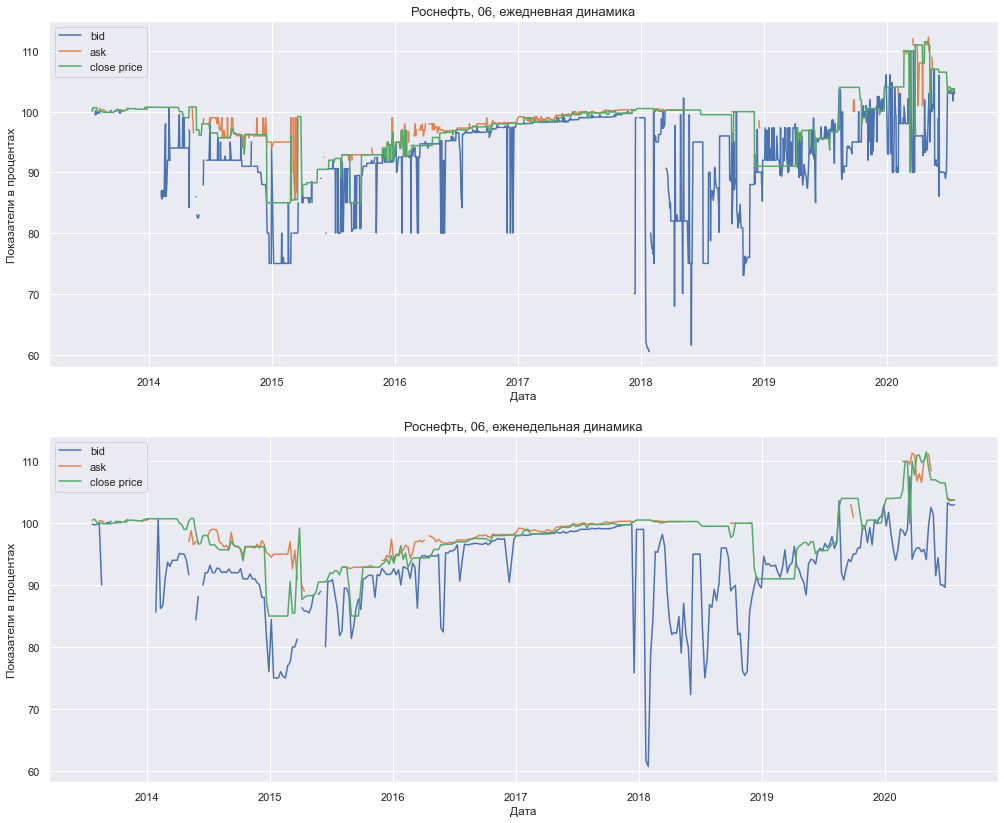

In [33]:
fig, ax = plt.subplots(2, 1, figsize=(17, 14))

bond_name = 'Роснефть, 06'

data = all_daily_data.loc[all_daily_data.bond == bond_name]

sns.lineplot(x=data.loc[:, 'date'], 
             y=data.loc[:, 'bid'], label='bid', ax=ax[0])
sns.lineplot(x=data.loc[:, 'date'], 
             y=data.loc[:, 'ask'], label='ask', ax=ax[0])
sns.lineplot(x=data.loc[:, 'date'], 
             y=data.loc[:, 'close_price'], label='close price', ax=ax[0])
ax[0].set_xlabel('Дата', fontsize=12)
ax[0].set_ylabel('Показатели в процентах', fontsize=12)
ax[0].set_title(bond_name + ', ежедневная динамика', fontsize=13)

data = all_weekly_data.loc[all_weekly_data.bond == bond_name]

sns.lineplot(x=data.loc[:, 'date'], 
             y=data.loc[:, 'bid'], label='bid', ax=ax[1])
sns.lineplot(x=data.loc[:, 'date'], 
             y=data.loc[:, 'ask'], label='ask', ax=ax[1])
sns.lineplot(x=data.loc[:, 'date'], 
             y=data.loc[:, 'close_price'], label='close price', ax=ax[1])
ax[1].set_xlabel('Дата', fontsize=12)
ax[1].set_ylabel('Показатели в процентах', fontsize=12)
ax[1].set_title(bond_name + ', еженедельная динамика', fontsize=13)

plt.show()

In [34]:
public_companies = set(oblig_discrip_data.Эмитент).intersection(set(stock_discrip_data.company))
bonds_of_public = oblig_discrip_data.loc[oblig_discrip_data.Эмитент.isin(public_companies), 'Бумага'].tolist()

In [35]:
oblig_discrip_data.loc[oblig_discrip_data.Бумага.isin(
    list(all_weekly_data.loc[~all_weekly_data.bond.isin(bonds_of_public)].bond.value_counts().head(500).index)), 
                       'Эмитент'].value_counts().head(11)

Альфа-Банк            23
Газпромбанк           21
Банк ФК Открытие      20
ГТЛК                  17
Россельхозбанк        16
ДОМ.РФ                15
РЖД                   12
ВЭБ                   10
ВЭБ-лизинг            10
Русфинанс Банк         9
АКБ Пересвет (ПАО)     8
Name: Эмитент, dtype: int64

In [36]:
all_weekly_data = all_weekly_data.loc[all_weekly_data.bond.isin(bonds_of_public)]
all_weekly_data.shape

(67677, 27)

Прежде всего, удалим бонды облигации с "рваной" информацией.

In [37]:
all_weekly_data['cum_count'] = all_weekly_data.groupby(['bond']).cumcount() + 1

In [38]:
all_weekly_data = all_weekly_data[~((all_weekly_data.cum_count <= 16) & (all_weekly_data.g_spread_bp.isna()))]

In [39]:
all_weekly_data.groupby('bond')['g_spread_bp'].apply(lambda x: x.isna().sum()).loc[
    all_weekly_data.groupby('bond')['g_spread_bp'].apply(lambda x: x.isna().sum() > 0)]

bond
Ашинский метзавод, БО-01                             333
БАНК УРАЛСИБ, 04                                       1
БАНК УРАЛСИБ, 05                                       1
Банк Держава, БО-01                                  276
Банк Санкт-Петербург, БО-08                            1
ВТБ, Б-1-25                                            1
ВТБ, Б-1-3                                             1
ВТБ, Б-1-33                                            1
ВТБ, Б-1-35                                            1
ВТБ, Б-1-36                                            1
ВТБ, Б-1-6                                             1
ВТБ, СУБ-Т2-2                                          9
ГЕОТЕК Сейсморазведка, 01                            134
Группа компаний Самолет, БО-П06                       36
Детский мир, БО-04                                     1
ИНГРАД (ПАО), 001P-01                                111
ИНГРАД (ПАО), БО-01                                  147
КАМАЗ, БО-09              

In [40]:
dirty_bonds = list(all_weekly_data.groupby('bond')['g_spread_bp'].apply(lambda x: x.isna().sum()).loc[
    all_weekly_data.groupby('bond')['g_spread_bp'].apply(lambda x: x.isna().sum() > 0)].index)

all_weekly_data = all_weekly_data.loc[~all_weekly_data.bond.isin(dirty_bonds)]
all_weekly_data.shape

(56650, 28)

In [41]:
all_weekly_data.describe(percentiles=[0.0025, 0.005, 0.01, 0.05, 0.95, 0.99, 0.995, 0.9975])

,bid,ask,bid_ask_bp,market_price,admitted_price,close_price,indicative,turnover,num_of_deals,turnover_in_securities,current_coupon,ytm_ind_p,ytm_close_p,accrued_interest,duration,mod_duration,ytm_oferta_ind_p,ytm_oferta_close_p,dur_to_p_c_date,mod_dur_to_p_c_date,g_spread_bp,cum_count
count,56023.000000,54010.000000,53730.000000,53214.000000,53219.000000,56533.000000,56563.000000,4.906600e+04,49066.000000,4.906600e+04,44132.000000,3.761100e+04,3.403800e+04,55697.000000,37585.000000,37541.000000,21778.000000,17418.000000,21778.000000,21739.000000,5.665000e+04,56650.000000
mean,98.145895,101.469863,296.891037,100.116867,100.318269,100.165593,100.059620,1.314829e+07,22.876273,1.311153e+04,5.268681,1.305194e+04,1.442047e+04,258.635712,929.556427,2.439197,9.767556,8.143830,733.328203,1.859480,8.662475e+05,79.239382
std,7.248416,6.005741,552.827035,5.224721,5.385938,5.400118,5.332331,5.693164e+07,135.249384,5.679562e+04,4.136816,2.530161e+06,2.659644e+06,7924.290290,530.187996,1.420090,220.047007,69.951074,449.253344,1.138413,2.061606e+08,70.761366
min,44.940000,45.548333,1.000000,42.240000,42.240000,45.178333,42.240000,2.500000e+02,1.000000,1.000000e+00,0.010000,-6.153635e+01,-6.324515e+01,0.010000,1.000000,0.000049,-63.551736,-63.544759,1.000000,0.001551,-6.636611e+03,1.000000
0.2%,60.236220,72.830900,1.800000,71.438471,70.358630,71.540500,71.252470,9.300000e+02,1.000000,1.000000e+00,0.010000,-1.774484e+01,-1.962148e+01,0.010000,6.000000,0.014741,-15.999939,-18.798057,12.000000,0.027858,-1.925723e+03,1.000000
0.5%,61.464400,81.075200,2.750000,78.809430,78.769510,77.810000,77.810000,9.600000e+02,1.000000,1.000000e+00,0.010000,-1.057622e+01,-1.248711e+01,0.010000,13.000000,0.033629,-8.545321,-10.322034,16.000000,0.040781,-1.312133e+03,1.000000
1%,67.872840,87.080450,3.800000,85.208600,85.166880,84.321600,84.409920,9.899650e+02,1.000000,1.000000e+00,0.010000,-6.280306e+00,-7.552414e+00,0.010000,27.420000,0.070888,-4.075740,-5.293542,25.000000,0.065038,-9.926891e+02,2.000000
5%,85.628000,93.764075,8.600000,91.900000,91.980000,91.665200,91.650000,3.001662e+03,1.000000,3.000000e+00,0.010000,-1.200864e+00,-1.482288e+00,0.020000,137.000000,0.350096,0.243630,-0.023939,85.000000,0.224952,-6.262689e+02,5.000000
50%,99.926000,101.000000,97.708333,100.444500,100.540000,100.460000,100.404000,7.975203e+05,4.000000,8.053000e+02,6.900000,5.799991e+00,5.270998e+00,11.390000,879.826594,2.277822,8.371907,7.800463,692.382837,1.772981,8.021007e+01,56.000000
95%,106.000000,109.973650,1314.555000,106.856700,107.550400,107.324000,107.127800,6.062722e+07,84.800000,6.029805e+04,11.250000,1.224913e+01,1.009477e+01,41.420000,1783.589194,4.815032,12.886836,11.628299,1480.676990,3.752577,3.790172e+02,226.000000


Сначала сделаем 95% винзоризацию

In [42]:
from scipy.stats import mstats

def winsorize_series(group):
    return mstats.winsorize(group, limits=[0.025, 0.025])

numeric_cols = all_weekly_data.select_dtypes(include=np.number).columns.tolist()

for col in numeric_cols:
    all_weekly_data[col] = all_weekly_data.groupby('bond')[col].transform(winsorize_series)

In [43]:
all_weekly_data.describe(percentiles=[0.0025, 0.005, 0.01, 0.05, 0.95, 0.99, 0.995, 0.9975])

,bid,ask,bid_ask_bp,market_price,admitted_price,close_price,indicative,turnover,num_of_deals,turnover_in_securities,current_coupon,ytm_ind_p,ytm_close_p,accrued_interest,duration,mod_duration,ytm_oferta_ind_p,ytm_oferta_close_p,dur_to_p_c_date,mod_dur_to_p_c_date,g_spread_bp,cum_count
count,56146.000000,54163.000000,53877.000000,53335.000000,53284.000000,56578.000000,56608.000000,4.919800e+04,49198.000000,4.919800e+04,44132.000000,3.760900e+04,34064.000000,55825.000000,37583.000000,37543.000000,21785.000000,17425.000000,21785.000000,21744.000000,56650.000000,56650.000000
mean,98.216441,101.494955,297.425576,100.143530,100.339210,100.180010,100.075685,1.274374e+07,22.735483,1.270736e+04,5.268681,1.305263e+04,4.593140,258.096617,929.621695,2.439459,8.270520,8.153741,733.660259,1.860170,5.154691,79.240229
std,7.057468,5.968641,552.364383,5.182184,5.293717,5.314846,5.265119,5.163165e+07,134.530222,5.149840e+04,4.136816,2.530228e+06,6.060990,7915.254582,529.861204,1.419243,16.188077,69.874274,448.329990,1.136065,2395.007081,70.618126
min,51.027500,51.708000,1.000000,49.980000,51.145000,51.573333,51.394000,5.050000e+02,1.000000,1.000000e+00,0.010000,-5.270472e+01,-62.497646,0.010000,1.000000,0.000258,-57.211869,-47.092296,5.500000,0.013319,-5673.468075,1.000000
0.2%,60.370000,72.880125,2.200000,72.225030,71.222393,71.754585,71.720490,9.617865e+02,1.000000,1.000000e+00,0.010000,-1.610009e+01,-17.469569,0.010000,13.000000,0.033340,-15.194487,-18.506408,20.000000,0.050535,-1631.440825,2.000000
0.5%,62.837575,82.053620,3.200000,79.839740,80.000000,78.242000,78.412600,9.800000e+02,1.000000,1.000000e+00,0.010000,-9.310555e+00,-10.485881,0.010000,20.500000,0.050621,-7.247859,-9.486805,24.500000,0.059919,-1215.811553,2.000000
1%,70.003800,87.599240,4.250000,85.508450,85.880000,85.010000,84.894770,1.000000e+03,1.000000,1.000000e+00,0.010000,-5.677145e+00,-6.965396,0.010000,34.000000,0.086709,-3.598850,-4.777217,33.000000,0.085446,-964.545300,2.000000
5%,85.894250,93.836150,9.000000,91.971400,92.100000,91.752000,91.700000,3.176603e+03,1.000000,3.000000e+00,0.010000,-1.156748e+00,-1.441812,0.020000,137.062513,0.352048,0.267555,0.009365,87.000000,0.227916,-622.841495,6.000000
50%,99.940000,101.000000,98.000000,100.450000,100.546000,100.465000,100.406000,8.086487e+05,4.000000,8.150000e+02,6.900000,5.803347e+00,5.277791,11.390000,879.738361,2.277822,8.375433,7.809859,693.185917,1.773839,80.305009,56.000000
95%,105.979500,109.975900,1305.200000,106.880000,107.508000,107.272450,107.081300,6.084457e+07,85.000000,6.051372e+04,11.250000,1.224062e+01,10.095855,41.420000,1783.589247,4.814335,12.842752,11.618828,1477.987308,3.742851,371.630658,226.000000


Видим снова выбросы по некоторым характеристикам, удалим полностью бонды c такими показателями, для остальных бондов проведём дополнительно винзоризацию.

In [44]:
cols = ['bid_ask_bp']

lower_bound = all_weekly_data[cols].quantile(0.00)
upper_bound = all_weekly_data[cols].quantile(0.995)

bad_bonds = all_weekly_data.loc[((all_weekly_data[cols] < lower_bound) |
                                 (all_weekly_data[cols] > upper_bound)).any(axis=1), 'bond'].value_counts()
bad_bad_bonds = list(bad_bonds.index)
len(bad_bad_bonds)

64

In [45]:
all_weekly_data = all_weekly_data.loc[~all_weekly_data.bond.isin(bad_bad_bonds)]
all_weekly_data.shape

(46946, 28)

In [46]:
all_weekly_data.describe(percentiles=[0.0025, 0.005, 0.01, 0.05, 0.95, 0.99, 0.995, 0.9975])

,bid,ask,bid_ask_bp,market_price,admitted_price,close_price,indicative,turnover,num_of_deals,turnover_in_securities,current_coupon,ytm_ind_p,ytm_close_p,accrued_interest,duration,mod_duration,ytm_oferta_ind_p,ytm_oferta_close_p,dur_to_p_c_date,mod_dur_to_p_c_date,g_spread_bp,cum_count
count,46717.000000,45790.000000,45618.000000,44809.000000,44646.000000,46901.000000,46925.000000,4.266800e+04,42668.000000,4.266800e+04,37007.000000,3.269000e+04,29745.000000,46187.000000,32664.000000,32624.000000,16661.000000,13442.000000,16661.000000,16625.000000,46946.000000,46946.000000
mean,98.768352,101.136234,227.182898,99.951738,100.142479,100.014631,99.913324,1.187747e+07,25.642384,1.183211e+04,5.159923,1.501589e+04,4.587773,308.132332,910.981452,2.394202,7.705228,6.905700,780.127766,1.980879,1.794298,72.376411
std,6.018102,5.623845,390.654823,5.249743,5.208028,5.254226,5.212934,4.726672e+07,144.186866,4.711092e+04,4.047529,2.713927e+06,6.203662,8701.185989,522.556117,1.407846,4.086696,4.228401,455.014405,1.152198,2609.618554,66.233398
min,51.027500,51.708000,1.000000,49.980000,51.145000,51.573333,51.394000,8.260000e+02,1.000000,1.000000e+00,0.010000,-5.270472e+01,-62.497646,0.010000,1.000000,0.000258,-57.211869,-47.092296,5.500000,0.013319,-5673.468075,1.000000
0.2%,66.072495,67.931515,2.000000,66.906880,67.641806,68.709000,68.401030,9.650000e+02,1.000000,1.000000e+00,0.010000,-1.618444e+01,-17.546779,0.010000,12.828750,0.030245,-14.214696,-15.936433,20.825000,0.057946,-1724.637087,2.000000
0.5%,73.715800,81.586940,3.000000,78.159600,80.872500,78.121000,78.103160,9.850000e+02,1.000000,1.000000e+00,0.010000,-9.630914e+00,-10.485881,0.010000,20.000000,0.049530,-7.442890,-9.416925,27.000000,0.073659,-1276.949088,2.000000
1%,77.616800,87.243400,4.000000,84.902080,85.837933,84.710000,84.716480,1.002000e+03,1.000000,1.000000e+00,0.010000,-5.340251e+00,-6.436692,0.010000,30.000000,0.076400,-3.288581,-4.522213,37.000000,0.106485,-948.005932,2.000000
5%,88.571200,93.550900,8.200000,91.706000,92.140000,91.816000,91.740000,4.644285e+03,1.000000,4.500000e+00,0.010000,-9.132541e-01,-1.149821,0.020000,132.000000,0.339268,0.283254,0.039288,99.000000,0.263176,-612.680966,6.000000
50%,99.998000,100.930000,81.750000,100.402000,100.472000,100.414000,100.362500,9.044744e+05,4.750000,9.195000e+02,6.900000,5.700853e+00,5.249027,10.616000,858.062931,2.224432,8.112806,7.493853,757.559192,1.924440,78.899072,50.000000
95%,105.570000,108.564000,944.200000,106.200000,106.598000,106.452000,106.260000,5.746740e+07,95.000000,5.731367e+04,9.900000,1.225856e+01,9.881443,40.054000,1772.000000,4.795539,12.640173,11.272613,1510.604936,3.841164,370.714211,208.000000


In [47]:
cols = ['g_spread_bp']

lower_bound = all_weekly_data[cols].quantile(0.0025)
upper_bound = all_weekly_data[cols].quantile(0.9975)

bad_bonds = all_weekly_data.loc[((all_weekly_data[cols] < lower_bound) |
                                 (all_weekly_data[cols] > upper_bound)).any(axis=1), 'bond'].value_counts()
bad_bad_bonds = list(bad_bonds.index)
len(bad_bad_bonds)

10

In [48]:
all_weekly_data = all_weekly_data.loc[~all_weekly_data.bond.isin(bad_bad_bonds)]
all_weekly_data.shape

(45982, 28)

In [49]:
all_weekly_data.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

,bid,ask,bid_ask_bp,market_price,admitted_price,close_price,indicative,turnover,num_of_deals,turnover_in_securities,current_coupon,ytm_ind_p,ytm_close_p,accrued_interest,duration,mod_duration,ytm_oferta_ind_p,ytm_oferta_close_p,dur_to_p_c_date,mod_dur_to_p_c_date,g_spread_bp,cum_count
count,45754.000000,44845.000000,44674.000000,44006.000000,43817.000000,45938.000000,45962.000000,4.183000e+04,41830.000000,4.183000e+04,36619.000000,31864.000000,29166.000000,45234.000000,31864.000000,31798.000000,16494.000000,13326.000000,16494.000000,16462.000000,45982.000000,45982.000000
mean,98.850446,101.196052,224.936033,99.999369,100.184858,100.086005,99.981593,1.209386e+07,25.833831,1.203253e+04,5.175894,5.127817,4.526512,314.428392,923.172341,2.427340,7.712572,6.924591,786.134024,1.995921,-23.277311,72.214106
std,5.306998,4.788583,388.602838,4.413772,4.381435,4.417495,4.374923,4.771135e+07,145.576405,4.755615e+04,4.029184,4.241321,3.859319,8792.260070,521.364489,1.404509,4.033199,4.168357,453.253012,1.147644,318.637527,66.142820
min,60.015000,79.460000,1.000000,62.380000,74.978000,74.978000,75.563333,8.260000e+02,1.000000,1.000000e+00,0.010000,-13.275703,-28.995443,0.010000,1.000000,0.002848,-57.211869,-47.092296,5.500000,0.013319,-1724.637087,1.000000
1%,80.800000,88.996660,4.000000,86.772983,87.173280,86.900000,87.101710,1.002300e+03,1.000000,1.000000e+00,0.010000,-3.833304,-4.325247,0.010000,33.657500,0.083032,-2.979873,-4.143279,41.000000,0.109213,-862.584077,2.000000
5%,89.098600,93.874400,8.200000,91.962000,92.459600,92.200000,92.036100,4.906625e+03,1.000000,5.000000e+00,0.010000,-0.736119,-0.904192,0.020000,140.000000,0.357662,0.321816,0.060417,103.750000,0.273662,-598.283094,6.000000
25%,96.500000,99.258000,27.000000,98.070000,98.142500,98.111750,98.000000,1.260222e+05,2.200000,1.252708e+02,0.010000,1.406886,1.150732,0.210000,509.508826,1.315475,6.222572,5.838829,425.546613,1.069573,-191.794696,22.000000
50%,100.000000,100.930000,80.400000,100.408000,100.474000,100.422000,100.370000,9.314451e+05,4.800000,9.356750e+02,6.900000,5.699027,5.268461,10.800000,873.701176,2.260964,8.108551,7.489996,766.302993,1.941671,78.646186,50.000000
75%,101.880000,103.202500,261.750000,102.410000,102.594000,102.474000,102.376000,5.491616e+06,17.000000,5.403725e+03,8.450000,7.977049,7.335562,24.050000,1348.673647,3.473198,9.729237,9.187526,1110.420588,2.835835,148.207762,105.000000
95%,105.497675,108.327400,926.810000,106.083500,106.480000,106.317575,106.136000,5.876073e+07,95.800000,5.843848e+04,9.900000,11.734349,9.698242,40.130000,1773.969501,4.800675,12.642547,11.261223,1511.645811,3.846230,331.532995,207.000000


Посмотрим на длины временных рядов по облигациям

In [50]:
all_weekly_data.bond.value_counts()

ИРКУТ, БО-04                                      388
Роснефть, 06                                      367
Роснефть, 10                                      363
Башнефть, 08                                      352
Башнефть, 07                                      348
                                                 ... 
ВТБ, Б-1-161                                       15
Группа Черкизово, БО-001Р-04                       15
ТрансФин-М, БО-24                                  14
Сбербанк России, ИОС_PRT_SBPPRP85-5Y-001Р-383R     14
ВТБ, Б-1-34                                        11
Name: bond, Length: 552, dtype: int64

In [51]:
all_weekly_data['counted_vals'] = all_weekly_data.groupby('bond')['bond'].transform('count')
all_weekly_data = all_weekly_data.loc[all_weekly_data.counted_vals > 14]
all_weekly_data.shape

(45943, 29)

In [52]:
all_weekly_data.bond.value_counts()

ИРКУТ, БО-04                                      388
Роснефть, 06                                      367
Роснефть, 10                                      363
Башнефть, 08                                      352
Башнефть, 07                                      348
                                                 ... 
ВТБ, Б-1-159                                       15
Сбербанк России, ИОС_PRT_SBERPRPT-5Y-001Р-374R     15
ВТБ, Б-1-160                                       15
ВТБ, Б-1-32                                        15
ВТБ, Б-1-161                                       15
Name: bond, Length: 549, dtype: int64

In [53]:
all_weekly_data.date.dt.year.value_counts().reset_index().sort_values('index')

,index,date
9,2012,93
8,2013,1552
5,2014,2221
6,2015,2049
7,2016,1833
4,2017,2877
3,2018,4428
1,2019,7274
0,2020,16717
2,2021,6899


In [54]:
all_weekly_data['exchange'].value_counts()

Московская Биржа       26166
Московская биржа Т+    19777
Name: exchange, dtype: int64

Добавим к нашей таблице информацию об эмитенте, секторе; добавим столбец с номером месяца

In [55]:
dict_bond_company = dict(zip(oblig_discrip_data['Бумага'].tolist(), oblig_discrip_data['Эмитент'].tolist()))
all_weekly_data.loc[:, 'company'] = all_weekly_data['bond'].map(dict_bond_company)
dict_company_sector = dict(zip(oblig_discrip_data['Эмитент'].tolist(), oblig_discrip_data['Отрасль'].tolist()))
all_weekly_data.loc[:, 'sector'] = all_weekly_data['company'].map(dict_company_sector)

all_weekly_data.loc[:, 'year_num'] = all_weekly_data.date.dt.year
all_weekly_data.loc[:, 'quarter_num'] = all_weekly_data.date.dt.quarter
all_weekly_data.loc[:, 'month_num'] = all_weekly_data.date.dt.month
all_weekly_data.loc[:, 'week_num'] = all_weekly_data.date.dt.week

Посмотрим, кто главные эмитенты (топ10) в нашей выборке, и сколько процентов выборки они состоавляют (по количеству бондов)

In [56]:
print(all_weekly_data.drop_duplicates(subset=['bond']).company.value_counts(normalize=True).head(10).sum() * 100)
all_weekly_data.drop_duplicates(subset=['bond']).company.value_counts(normalize=True).head(10) * 100

76.50273224043717


Сбербанк России              36.794171
ВТБ                          20.947177
Московский кредитный банк     4.007286
АФК Система                   2.914390
МТС                           2.732240
Роснефть                      2.550091
Магнит                        2.003643
Транснефть                    1.639344
ФСК ЕЭС                       1.457195
Ростелеком                    1.457195
Name: company, dtype: float64

Посмотрим на количество облигаций по секторам

In [57]:
all_weekly_data.drop_duplicates(subset=['bond']).sector.value_counts()

Банки                                          346
Связь и телекоммуникация                        45
Нефтегазовая отрасль                            36
Энергетика                                      30
Торговля и ритэйл                               17
Строительство и девелопмент                     14
Черная металлургия                              12
Химическая и нефтехимическая промышленность     11
Горнодобывающая промышленность                   9
Пищевая промышленность                           8
Машиностроение                                   8
Финансовые институты                             7
Транспорт                                        3
Образование                                      2
Цветная металлургия                              1
Name: sector, dtype: int64

Чуть укоротим названия секторов

In [58]:
all_weekly_data.sector.replace({'Пищевая промышленность': 'Пищевая пром',
#                                 'Банки', 
                                'Связь и телекоммуникация': 'Связь/телеком',
                                'Черная металлургия': 'Черная метал.', 
                                'Нефтегазовая отрасль': 'Нефть и газ',
#                                 'Энергетика',
#                                 'Образование', 
                                'Машиностроение': 'Машиностр',
                                'Торговля и ритэйл': 'Торговля',
                                'Строительство и девелопмент': 'Строительство',
                                'Химическая и нефтехимическая промышленность': 'Хим/нефтехим',
#                                 'Транспорт',
                                'Горнодобывающая промышленность': 'Горнодобыча', 
                                'Цветная металлургия': 'Цвет. метал.', 
                                'Другие отрасли': 'Другие',
                                'Финансовые институты': 'Фин институты',
#                                 'Информационные и высокие технологии': 'Высокие техно',
#                                 'АПК и сельское хозяйство': 'АПК и с/х',
#                                 'Медицина и здравоохранение': 'Медицина',
                               }, inplace=True)

Добавим информацию о размере эмиссии

In [59]:
dict_bond_issuance = dict(zip(oblig_discrip_data['Бумага'].tolist(), 
                              oblig_discrip_data['Объем эмиссии'].tolist()))
dict_bond_reg_date = dict(zip(oblig_discrip_data['Бумага'].tolist(), 
                              oblig_discrip_data['Расчетная дата начала обращения'].tolist()))

all_weekly_data.loc[:, 'issuance'] = all_weekly_data.bond.map(dict_bond_issuance)
all_weekly_data.loc[:, 'reg_date'] = all_weekly_data.bond.map(dict_bond_reg_date)

### Создание новых признаков по временным рядам (интегрирование, логарифмирование и т.д.)

Создаём переменную количества дней до погашения и дней в обращении

In [60]:
all_weekly_data.loc[:, 'days_left'] = (all_weekly_data.maturity - all_weekly_data.date).dt.days
all_weekly_data.loc[:, 'days_passed'] = (all_weekly_data.date - all_weekly_data.reg_date).dt.days

Проведём сортировку по бумаге и датам

In [61]:
all_weekly_data.sort_values(['bond', 'date'], ascending=[True, True], inplace=True)
all_weekly_data.reset_index(drop=True, inplace=True)
all_weekly_data.head(3)

,date,bid,ask,bid_ask_bp,market_price,admitted_price,close_price,indicative,turnover,num_of_deals,turnover_in_securities,current_coupon,ytm_ind_p,ytm_close_p,accrued_interest,duration,mod_duration,ytm_oferta_ind_p,ytm_oferta_close_p,dur_to_p_c_date,mod_dur_to_p_c_date,g_spread_bp,exchange,indicative_type,maturity,put_call_date,bond,cum_count,counted_vals,company,sector,year_num,quarter_num,month_num,week_num,issuance,reg_date,days_left,days_passed
0,2012-11-11,100.000,100.1375,13.75,100.176667,100.276667,100.0725,100.1375,82745708.70,9.0,82476.00,NaN,9.089402,NaN,1.3325,945.402288,NaN,NaN,NaN,NaN,NaN,214.085654,Московская Биржа,Avg,2015-10-30,NaT,"АЛРОСА, БО-01",4,155,АЛРОСА,Горнодобыча,2012,4,11,45,5.000000e+09,2012-11-06,1083,5.0
1,2012-11-18,100.006,100.0400,6.00,100.040000,100.272000,100.0200,100.0280,756750.25,1.5,756.75,NaN,9.133786,NaN,2.9080,945.402288,NaN,NaN,NaN,NaN,NaN,215.828005,Московская Биржа,Avg,2015-10-30,NaT,"АЛРОСА, БО-01",4,155,АЛРОСА,Горнодобыча,2012,4,11,46,5.000000e+09,2012-11-06,1076,12.0
2,2012-11-25,100.210,100.2700,6.00,100.176000,100.280000,100.2140,100.2060,25059438.25,4.5,25010.25,NaN,9.059162,NaN,4.6060,945.402288,NaN,NaN,NaN,NaN,NaN,228.104924,Московская Биржа,Avg,2015-10-30,NaT,"АЛРОСА, БО-01",4,155,АЛРОСА,Горнодобыча,2012,4,11,47,5.000000e+09,2012-11-06,1069,19.0


Нормируем оборот на размер эмиссии и добавление интегрированного ряда (первого порядка)

In [62]:
all_weekly_data.loc[:, 'turnover_norm'] = all_weekly_data.turnover / all_weekly_data.issuance
# all_weekly_data.loc[:, 'turnover_norm_diff'] = all_weekly_data.turnover.diff()

Добавляем три переменные по бид-аск спреду и одну по g-спреду

In [63]:
all_weekly_data.loc[:, 'prop_bid_ask'] = all_weekly_data.bid_ask_bp * 2 / (all_weekly_data.bid+all_weekly_data.ask)

# all_weekly_data.loc[:, 'bid_ask_bp_diff'] = all_weekly_data.groupby('bond').bid_ask_bp.diff()

# all_weekly_data.loc[:, 'bid_ask_bp_ln'] = all_weekly_data.bid_ask_bp.apply(np.log)
# all_weekly_data.loc[:, 'bid_ask_bp_ln_diff'] = all_weekly_data.groupby('bond').bid_ask_bp_ln.diff()

# all_weekly_data.loc[:, 'g_spread_bp_diff'] = all_weekly_data.groupby('bond').g_spread_bp.diff()

## Добавление рейтингов и макро индексов и присоединение двух панелей

In [64]:
# кривая доходности (двухгодичная)
yield2y = pd.read_excel('CommonIndexes.xlsx', sheet_name='YieldCurve2Y', usecols='A:B',
                        skiprows=7, parse_dates=['Дата'], index_col='Дата').resample('W').mean().reset_index()
yield2y.rename(columns={'Дата': 'date', 'RUB Yield Curve 2Y': 'yield2y'}, inplace=True)

# кривая доходности (десятилетняя)
yield10y = pd.read_excel('CommonIndexes.xlsx', sheet_name='YieldCurve10Y', usecols='A:B',
                         skiprows=7, parse_dates=['Дата'], index_col='Дата').resample('W').mean().reset_index()
yield10y.rename(columns={'Дата': 'date', 'RUB Yield Curve 10Y': 'yield10y'}, inplace=True)

# индекс Мос Биржи
moex = pd.read_excel('CommonIndexes.xlsx', sheet_name='MOEXindex', usecols='A:B',
                     skiprows=7, parse_dates=['Дата'], index_col='Дата').resample('W').mean().reset_index()
moex.rename(columns={'Дата': 'date', 'Индекс МосБиржи': 'moex'}, inplace=True)

moex['moex_ret'] = moex.moex.pct_change()

# котировки нефти марки Brent
brent = pd.read_excel('CommonIndexes.xlsx', sheet_name='Brent', usecols='A:B',
                      skiprows=7, parse_dates=['Дата'], index_col='Дата').resample('W').mean().reset_index()
brent.rename(columns={'Дата': 'date', 'Нефть Brent': 'brent'}, inplace=True)

# ставка рефинансирования
ref_rate = pd.read_excel('CommonIndexes.xlsx', sheet_name='RefinancingRate', usecols='A:B',
                         skiprows=7, parse_dates=['Дата'], index_col='Дата').resample('W').mean().reset_index()
ref_rate.rename(columns={'Дата': 'date', 'Ставка рефинансирования ЦБ РФ': 'ref_rate'}, inplace=True)

# курс доллара
usdrub = pd.read_excel('CommonIndexes.xlsx', sheet_name='USDRUB', usecols='A:B',
                         skiprows=7, parse_dates=['Дата'], index_col='Дата').resample('W').mean().reset_index()
usdrub.rename(columns={'Дата': 'date', 'USDRUB_TOD': 'usdrub'}, inplace=True)

# соединяем
all_weekly_data = all_weekly_data.merge(yield2y, how='left', on='date'
                                       ).merge(yield10y, how='left', on='date'
                                              ).merge(moex, how='left', on='date'
                                                     ).merge(brent, how='left', on='date'
                                                            ).merge(ref_rate, how='left', on='date'
                                                                   ).merge(usdrub, how='left', on='date')

# и добавляем переменную наклона
all_weekly_data['slope'] = all_weekly_data.yield10y - all_weekly_data.yield2y

Добавим информацию о рейтинге эмитентов (три версии: изначальную, числовую, и обрезанную версию исходной)

In [65]:
oblig_discrip = oblig_discrip_data.rename(columns={'Бумага': 'bond', 'Рейтинг эмитента АКРА': 'rating'})

oblig_discrip['rating_num'] = oblig_discrip.rating.replace({'A(RU)': 3,
                                                            'A+(RU)': 3,
                                                            'A-(RU)': 3,
                                                            'AA(RU)': 2,
                                                            'AA+(RU)': 2,
                                                            'AA-(RU)': 2,
                                                            'AAA(RU)': 1,
                                                            'B+(RU)': 5,
                                                            'BB(RU)': 5,
                                                            'BB+(RU)': 5,
                                                            'BB-(RU)': 5,
                                                            'BBB(RU)': 4,
                                                            'BBB+(RU)': 4,
                                                            'BBB-(RU)': 4,
                                                            'Withdrawn': np.nan})

oblig_discrip['rating_cut'] = oblig_discrip.rating.replace({'A(RU)': 'A',
                                                            'A+(RU)': 'A',
                                                            'A-(RU)': 'A',
                                                            'AA(RU)': 'AA',
                                                            'AA+(RU)': 'AA',
                                                            'AA-(RU)': 'AA',
                                                            'AAA(RU)': 'AAA',
                                                            'B+(RU)': 'BB',
                                                            'BB(RU)': 'BB',
                                                            'BB+(RU)': 'BB',
                                                            'BB-(RU)': 'BB',
                                                            'BBB(RU)': 'BBB',
                                                            'BBB+(RU)': 'BBB',
                                                            'BBB-(RU)': 'BBB',
                                                            'Withdrawn': np.nan})

all_weekly_data = all_weekly_data.merge(oblig_discrip.loc[:, ['bond', 'rating', 
                                                              'rating_num', 'rating_cut']], 
                                        on=['bond'], how='left')

### Добавление признаков:
#### 1. расстояния до дефолта на основе долговых обязательств и рыночной капитализации
#### 2. меры неликвидности на основе данных рынка акций

Получим тикеры компаний, которые есть в нашей выборке и оставим только их в панели с котировками акций

In [66]:
tickers = stock_discrip_data_common.loc[stock_discrip_data_common.company.isin(all_weekly_data.company.unique()), 
                                        'Тикер'].tolist()
len(tickers)

47

In [67]:
stock_common_data = stock_common_data.loc[stock_common_data.SECID.isin(tickers)]
stock_common_data.shape

(77946, 17)

Создадим словарь для добавления столбца с названием компании

In [68]:
dict_ticker_company = dict(zip(stock_discrip_data['Тикер'].tolist(), stock_discrip_data['company'].tolist()))
stock_common_data['company'] = stock_common_data.SECID.map(dict_ticker_company)

In [69]:
# afks = stock_common_data.loc[stock_common_data.SECID == 'AFKS', ['TRADEDATE', 'daily_ret']][1:]
# from arch import arch_model
# am = arch_model(afks.daily_ret)
# res = am.fit()
# res.conditional_volatility

Открываем снова таблицу со списком облигаций и выделяем нужные (и уже переименованные) столбцы

In [70]:
oblig_emission_data = pd.read_excel('Список облигаций - clean.xlsx',
                                    parse_dates=['Дата начала размещения', 'Дата окончания размещения',
                                                 'Дата погашения', 'Дата начала начисления купонов',
                                                 'Расчетная дата начала обращения', 'Дата регистрации', 
                                                 'Дата торгов'])

oblig_emission_data.sort_values("Дата регистрации", ascending=False, inplace=True)

oblig_emission_data = oblig_emission_data.loc[oblig_emission_data.Эмитент.isin(all_weekly_data.company), 
                                              ['№ new', 'Бумага', 'Эмитент',
                                               'Объем эмиссии', 'Дата регистрации', 'Дата погашения']]

oblig_emission_data.sort_values(['Эмитент', 'Дата регистрации'], inplace=True)

oblig_emission_data.rename(columns={'Бумага': 'bond', 'Эмитент': 'company', 'Объем эмиссии': 'issuance', 
                                    'Дата погашения': 'date_mat', 'Дата регистрации': 'date_reg'}, inplace=True)

print(oblig_emission_data.shape)
oblig_emission_data.head(3)

(2384, 6)


,№ new,bond,company,issuance,date_reg,date_mat
24,25,"АЛРОСА, 05",АЛРОСА,500000000.0,2001-01-18,2002-03-15
25,26,"АЛРОСА, 06",АЛРОСА,600000000.0,2001-03-28,2003-05-14
26,27,"АЛРОСА, 07",АЛРОСА,600000000.0,2001-03-28,2003-07-03


Итерационно заполняем поля с обязательствами по облигациям.

In [71]:
all_weekly_data['liab_current'] = np.nan
all_weekly_data['liab_noncurrent'] = np.nan

for i in trange(all_weekly_data.shape[0]):
    # сохраняем нужную строчку
    row_data = all_weekly_data.iloc[i]
    
    # выделяем нужный кусок таблицы
    comp_data = oblig_emission_data.loc[oblig_emission_data.company == row_data['company']]
    # получаем расстояния между датами
    diff_data = (comp_data.loc[:, ['date_reg', 'date_mat']] - row_data['date']).apply(lambda x: x.dt.days) - 5
    
    # обязательствами признаем только те эмиссии, чьи даты регистрации после рассматриваемой
    # краткосрочными - меньше либо равно 365 до даты погашения, долгосрочными - больше 365
    liab_s = comp_data.loc[(diff_data.date_reg <= 0) & (diff_data.date_mat.between(0, 365)), 'issuance'].sum()
    liab_l = comp_data.loc[(diff_data.date_reg <= 0) & (diff_data.date_mat > 365), 'issuance'].sum()
    
    all_weekly_data.iloc[i, -2] = liab_s
    all_weekly_data.iloc[i, -1] = liab_l

100%|██████████| 45943/45943 [07:23<00:00, 103.57it/s]


Создаём переменную точки дефолта

In [72]:
all_weekly_data['default_point'] = all_weekly_data['liab_current'] + all_weekly_data['liab_noncurrent'] / 2
# all_weekly_data.head(3)

Оставляем в таблице с котировками акций только рассматриваемые компании

In [73]:
stock_discrip_data_common = stock_discrip_data_common.loc[
    stock_discrip_data_common.company.isin(all_weekly_data.company.unique())]

usdrub = pd.read_excel('CommonIndexes.xlsx', sheet_name='USDRUB', usecols='A:B', skiprows=7, parse_dates=['Дата'])
usdrub.rename(columns={'Дата': 'date', 'USDRUB_TOD': 'usdrub'}, inplace=True)

Добавим капитализацию в рублях на последние имеющиеся в выборке дни

In [74]:
stock_discrip_data_common['cap'] = stock_discrip_data_common['Капитализация, млн USD'] * 10**6 * usdrub.iloc[-1, 1]

Посмотрим, чьи котировки за 2021 год отсутствуют, и удалим данные компании

In [75]:
stock_common_data.groupby('SECID').apply(
    lambda x: x.iloc[-1]).loc[:, ['TRADEDATE', 'CLOSE', 'company']
                             ].reset_index(drop=True).sort_values('TRADEDATE').head(3)

,TRADEDATE,CLOSE,company
32,2019-10-08,1.3875,ЧЗПСН-Профнастил
39,2021-03-09,NaN,Светофор Групп
0,2021-04-23,35.6680,АФК Система


In [76]:
stock_common_data = stock_common_data[~stock_common_data.company.isin(['Светофор Групп', 'ЧЗПСН-Профнастил'])]
all_weekly_data = all_weekly_data[~all_weekly_data.company.isin(['Светофор Групп', 'ЧЗПСН-Профнастил'])]

Получим доходность акций и затем их волатильность; и переименуем пару столбцов

In [77]:
stock_common_data['daily_ret'] = stock_common_data.groupby('SECID')['CLOSE'].pct_change() * 100
stock_common_data.dropna(inplace=True)
stock_common_data['variance'] = (stock_common_data.daily_ret - stock_common_data.daily_ret.mean()) ** 2

stock_common_data.rename(columns={'CLOSE': 'close',
                                  'VALUE': 'trading_volume', 
                                  'TRADEDATE': 'date'}, inplace=True)

Оставим только интересующие нас столбцы

In [78]:
stock_common_mini_data = stock_common_data.loc[:, ['date', 'close', 'daily_ret', 'SECID',
                                                   'trading_volume', 'variance', 'company']]

Посчитаем примерное количество акций по каждой компании; далее считаем капитализацию за каждый день для каждой компании

In [79]:
last_observ_prices = stock_common_mini_data.groupby('SECID').apply(
    lambda x: x.iloc[-1]).loc[:, ['date', 'close', 'company']].reset_index(drop=True)
last_observ_prices = last_observ_prices.merge(stock_discrip_data_common.loc[:, ['company', 'cap']], how='left')
last_observ_prices['num_of_stocks'] = last_observ_prices.cap / last_observ_prices.close

In [80]:
stock_common_mini_data = stock_common_mini_data.merge(last_observ_prices.drop(columns=['close', 'date', 'cap']), 
                                                      on=['company'], how='left')
stock_common_mini_data['cap'] = stock_common_mini_data.num_of_stocks * stock_common_mini_data.close
stock_common_mini_data.head(3)

,date,close,daily_ret,SECID,trading_volume,variance,company,num_of_stocks,cap
0,2014-06-10,45.499,2.364561,AFKS,522319645.4,5.239356,АФК Система,9.485545e+09,4.315828e+11
1,2014-06-11,45.300,-0.437372,AFKS,215501200.9,0.263137,АФК Система,9.485545e+09,4.296952e+11
2,2014-06-16,45.999,1.543046,AFKS,822593112.0,2.153408,АФК Система,9.485545e+09,4.363256e+11


Сделаем недельное усреднение и присоединим информацию к нашему основному фрейму

In [84]:
stock_common = pd.DataFrame()
for c in stock_common_mini_data.company.unique():
    temp_data = stock_common_mini_data.loc[stock_common_mini_data.company == c]
    temp_data.set_index('date', inplace=True)
    
    temp_data = temp_data.resample('W').mean().reset_index()
    temp_data['company'] = c
    
    stock_common = pd.concat([stock_common, temp_data], axis=0)

In [85]:
all_weekly_data = all_weekly_data.merge(stock_common, on=['date', 'company'], how='inner')
all_weekly_data.shape

(40519, 61)

Добавим переменную дистанции до дефолта и вероятности дефолта на основе нормального распределения

In [86]:
all_weekly_data['dist_to_default'] = \
(all_weekly_data.cap - all_weekly_data.default_point) / \
(all_weekly_data.cap * (all_weekly_data.variance ** 0.5) * (252 ** 0.5))

In [88]:
from scipy.stats import norm

In [116]:
all_weekly_data['prop_of_default'] = all_weekly_data.dist_to_default.apply(lambda x: norm.cdf(-x))

Добавим переменную неликвидности по уже агрегированным данным

In [96]:
all_weekly_data['illiquidity'] = (all_weekly_data.variance / all_weekly_data.trading_volume) ** (1/3)

Ещё раз проверяем, что все бонды длиной не меньше 15

In [97]:
all_weekly_data = all_weekly_data.loc[~all_weekly_data.bond.isin(
    list(all_weekly_data.bond.value_counts()[all_weekly_data.bond.value_counts() < 15].index))]

Посмотрим на размер таблицы, количество компаний в выборке, количество бондов обычных и со встроенным опционом.

In [117]:
all_weekly_data.sort_values(['bond', 'date'], inplace=True)

In [118]:
all_weekly_data.shape, all_weekly_data.company.nunique(), \
all_weekly_data.groupby('bond').apply(lambda x: x.put_call_date.notna().any()).sum()

((40500, 64), 43, 161)

In [119]:
all_weekly_data.columns

Index(['date', 'bid', 'ask', 'bid_ask_bp', 'market_price', 'admitted_price',
       'close_price', 'indicative', 'turnover', 'num_of_deals',
       'turnover_in_securities', 'current_coupon', 'ytm_ind_p', 'ytm_close_p',
       'accrued_interest', 'duration', 'mod_duration', 'ytm_oferta_ind_p',
       'ytm_oferta_close_p', 'dur_to_p_c_date', 'mod_dur_to_p_c_date',
       'g_spread_bp', 'exchange', 'indicative_type', 'maturity',
       'put_call_date', 'bond', 'cum_count', 'counted_vals', 'company',
       'sector', 'year_num', 'quarter_num', 'month_num', 'week_num',
       'issuance', 'reg_date', 'days_left', 'days_passed', 'turnover_norm',
       'prop_bid_ask', 'yield2y', 'yield10y', 'moex', 'moex_ret', 'brent',
       'ref_rate', 'usdrub', 'slope', 'rating', 'rating_num', 'rating_cut',
       'liab_current', 'liab_noncurrent', 'default_point', 'close',
       'daily_ret', 'trading_volume', 'variance', 'num_of_stocks', 'cap',
       'dist_to_default', 'prop_of_default', 'illiquidity']

Сохранение подготовленного фрейма

In [120]:
all_weekly_data.to_pickle('prep_weekly_data.pkl')

In [121]:
plot_data = all_weekly_data.copy()

In [122]:
plot_data.rating_cut.fillna('Unknown', inplace=True)

(-500.0, 1000.0)

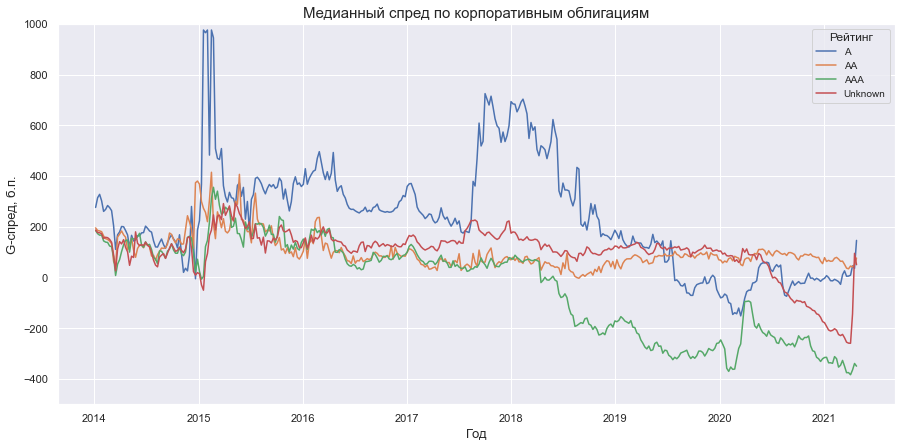

In [123]:
fig, ax = plt.subplots(figsize=(15, 7))
la = plot_data.loc[plot_data.date.dt.year > 2013
                  ].groupby(['rating_cut', 'date'])['g_spread_bp'].mean().reset_index()
sns.lineplot(data=la, x='date', y='g_spread_bp', hue='rating_cut')

plt.xlabel('Год', fontsize=13)
plt.ylabel('G-спред, б.п.', fontsize=13)
plt.title('Медианный спред по корпоративным облигациям', fontsize=15)

plt.legend(title='Рейтинг', fontsize=10)

plt.ylim(-500, 1000)

In [124]:
plot_data.groupby('rating_cut')['dist_to_default', 'prop_of_default'].median()

<ipython-input-124-44588249da38>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  plot_data.groupby('rating_cut')['dist_to_default', 'prop_of_default'].median()


,dist_to_default,prop_of_default
rating_cut,,
A,0.058412,0.476710
AA,0.046652,0.481395
AAA,0.036016,0.485635
Unknown,0.029737,0.488138
